In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import os
import math
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score
import seaborn as sns
from sklearn import metrics
from tqdm import tqdm

In [24]:
def make_data(x, str,w):
    x=pd.DataFrame(x)
    window=w
    for i in range(1, window):
        column=f'{str}_lag{i}'
        x[column]=x[str].shift(i)
    return x

def make_label(x, w):
    window=w
    x['label_all']=x['label']
    for i in range(1, window):
        x.loc[(x['label_all']==1)|(x['label'].shift(i)==1), 'label_all']=1
        x.loc[(x['label_all']==0)&(x['label'].shift(i)==0), 'label_all']=0
    
    x['label']=x['label_all']
    return x[['label']]

def calc_leq(df, unit):
    df.reset_index(inplace=True, drop=True)
    for i in range(int(len(df)/unit)+1):
        hour_df=df.loc[i*unit:(i+1)*unit, 'original'].copy()
        N=len(hour_df)
        Leq=10*np.log10(np.sum(np.power(10, hour_df/10)))-10*np.log10(N)
        df.loc[i*unit:(i+1)*unit, 'leq']=Leq
    return df

def leq_filter(df):
    df=calc_leq(df, 18000)
    df.loc[(df['original']<df['leq']), 'd']=0
    return df

def validate(test_v, anorm, thr):
    test_v['z']=np.where(anorm>=thr, 1, 0)
    test_v.reset_index(inplace=True, drop=True)

    #     適合率
    tp=test_v[(test_v['label']==1)&(test_v['z']==1)]
    z_p=test_v[test_v['z']==1]
    pre_score=len(tp)/len(z_p)

    #     再現率
    df_anorm=[]
    search= 1 if test_v.loc[0, 'label']==0 else 0
    for num in range(len(test_v)):
        if search==1 and test_v.loc[num, 'label']==search:
            start=num
            search=0
        elif search==0 and test_v.loc[num, 'label']==search:
            stop=num-1
            anorm_range=test_v.loc[start:stop].copy()
            df_anorm.append(anorm_range)
            search=1
            
    count=[]
    for i in range(len(df_anorm)):
        if len(df_anorm[i].loc[df_anorm[i]['z']==1])>=1:
               count.append(i)    

    re_score=len(count)/len(df_anorm)

    return pre_score, re_score

def figure(df_test, anorm, d, thr):
    df_test['z']=np.where(d>=thr, 1, 0)
    
    z=df_test['z'].values*100
    test_plot=df_test['original'].values
    num_ax=math.ceil(len(test_plot)/17999)
    label=df_test['label'].values*100
    label_index=range(len(label))
    time_unit=60
    time=[t*0.2/60 for t in range(len(anorm))]
    plt.rcParams["font.size"] = 30

    fig, ax=plt.subplots(num_ax, 1, figsize=(35, 15*num_ax))
    for i in range(num_ax):
        ax[i].plot(time, anorm, '-r',linewidth = 1 )
        ax[i].plot(time, test_plot, '-k',linewidth = 2)
        ax[i].fill_between(time, label, facecolor='lime' )
        ax[i].fill_between(time, z, facecolor='coral' )
        ax[i].set_ylim(0, 90)
        ax[i].set_xlim(i*time_unit, time_unit*(i+1))
        ax[i].set_xticks(np.arange(60*i, 60*(i+1)))
        ax[i].xaxis.set_tick_params(rotation=70)
    plt.show()

def fig_pr(test_v, d, bins):
    bins_1=int(bins*0.8)
    thr_1=np.linspace(d.min(), 0.6, bins_1)
    thr_2=np.linspace(0.6, d.max(), bins-bins_1)
    thresholds=np.concatenate([thr_1, thr_2])
    precision=np.array([])
    recall=np.array([])
    for i in thresholds:
        p, r=validate(test_v, d, i)
        precision=np.append(precision, p)
        recall=np.append(recall, r)

    auc = metrics.auc(recall, precision)
    f_score=(2*precision*recall)/(precision+recall)
    thr=thresholds[np.argmax(f_score)]

    plt.rcParams["font.size"] = 10
    plt.plot(recall, precision, marker='o', markevery=[np.argmax(f_score)], label='PR curve (AUC = %.2f)'%auc)
    plt.legend()
    plt.title('PR curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.show()

    return precision, recall, f_score, thresholds, thr, auc

def auc_gs(test_v, d, bins):
    bins_1=int(bins*0.8)
    thr_1=np.linspace(d.min(), 0.6, bins_1)
    thr_2=np.linspace(0.6, d.max(), bins-bins_1)
    thresholds=np.concatenate([thr_1, thr_2])
    precision=np.array([])
    recall=np.array([])
    for i in thresholds:
        p, r=validate(test_v, d, i)
        precision=np.append(precision, p)
        recall=np.append(recall, r)

    auc = metrics.auc(recall, precision)

    return auc

def fig_th_f(thresholds, f_score):
    plt.plot(thresholds, f_score, marker="o", markevery=[np.argmax(f_score)])
    plt.xlabel('thresholds')
    plt.ylabel('f_score')
    plt.grid(True)
    plt.show()
    
    return thresholds[np.argmax(f_score)], f_score.max()

In [25]:
data_dir='filtered_csv_label'
original = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
df = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
df=df[df['day']<=9]
df

,original,label,time,day
0,53.4,0,15,0
1,52.8,0,15,0
2,52.8,0,15,0
3,53.2,0,15,0
4,53.6,0,15,0
...,...,...,...,...
3995345,45.9,0,5,9
3995346,45.6,0,5,9
3995347,45.8,0,5,9
3995348,45.7,0,5,9


## ホールドアウト法
### 訓練、検証、テストへ分割
* 検証（チューニング用）：0日目
* テスト（最終評価用）：1 日目
* 訓練（学習用）：2, 3, 4, 5, 6, 7, 8, 9 日目

In [26]:
valid_day=[0]
test_day=[1]
train_day=[2, 3, 4, 5, 6, 7, 8, 9]

test_df=df[(df['day'].isin(test_day))].reset_index(drop=True)
valid_df=df[(df['day'].isin(valid_day))].reset_index(drop=True)
train_df=df[(df['day'].isin(train_day))].reset_index(drop=True)

## グリッドサーチ

## k近傍法のパラメータチューニング

In [27]:
print(f'訓練データ(学習用)：{train_day}日目')
print(f'検証データ（チューニング用）：{valid_day}日目')

window_list=[4, 5, 6, 7]
nk_list=[11, 12, 13, 14, 15, 16, 17, 18, 19]

best_score=0

for w in tqdm(window_list):
    df_list=[]
    for i in train_day:
        lag=[] 
        window=w
        lag.append(make_data(train_df.loc[train_df['day']==i, ['original']], 'original', window))
        lag.append(train_df.loc[train_df['day']==i, ['label']])
        df_add_lag=pd.concat(lag, axis=1)
        df_list.append(df_add_lag)
    train=pd.concat(df_list)
    train=train.dropna().reset_index(drop=True)
    
    df_list=[]
    for i in valid_day:
        lag=[] 
        window=w
        lag.append(make_data(valid_df.loc[valid_df['day']==i, ['original']], 'original', window))
        lag.append(valid_df.loc[valid_df['day']==i, ['label']])
        df_add_lag=pd.concat(lag, axis=1)
        df_list.append(df_add_lag)
    valid=pd.concat(df_list)
    valid=valid.dropna().reset_index(drop=True)
    
    #特徴量とラベルに分割
    train_x=train[train.columns[:-1]]
    train_y=train[[train.columns[-1]]]
    
    valid_x=valid[valid.columns[:-1]]
    valid_y=valid[[valid.columns[-1]]]
    
    for nk in nk_list:
        nk=nk
        neigh = NearestNeighbors(n_neighbors=nk)
        neigh.fit(train_x)
        d = neigh.kneighbors(valid_x)[0]
        d = np.mean(d, axis=1)

        test_v=valid[['original', 'label']].copy().reset_index(drop=True)
        test_v['d']=d

        #道路交通騒音に埋もれている異常音は正常とする
        test_v=leq_filter(test_v)
        test_v['d']=test_v['d']/test_v['d'].max()
        d_test=test_v['d'].values
        
        #AUC計算
        thr_bins=50
        auc = auc_gs(test_v, d_test, thr_bins)
        if auc>best_score:
            best_score=auc
            best_params={'window':w, 'nk':nk}
            print(f'更新AUC：{best_score}')
                    
print('==================================================================')
print(f'AUC最高：{best_score}')
print(f'パラメータ：{best_params}')

訓練データ(学習用)：[2, 3, 4, 5, 6, 7, 8, 9]日目
検証データ（チューニング用）：[0]日目


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

更新AUC：0.8472066991875088
更新AUC：0.847333752792345
更新AUC：0.847502707116884
更新AUC：0.8475526515983116
更新AUC：0.8478822386169498
更新AUC：0.8492047852857811


 25%|████████████████████                                                            | 1/4 [20:16<1:00:50, 1216.79s/it]

更新AUC：0.8650585760842608
更新AUC：0.8658947978054187


100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [1:38:44<00:00, 1481.10s/it]

AUC最高：0.8658947978054187
パラメータ：{'window': 5, 'nk': 12}


# チューニング結果
* window_list=[3, 5, 8, 10, 13, 17, 20]
* nk_list=[1, 5, 10, 15, 20, 25, 30, 35, 40]
## →best_params={'window': 5, 'nk': 15}
## →best_AUC=0.865695622660354
=============================================================  
* window_list=[4, 5, 6, 7]
* nk_list=[11, 12, 13, 14, 15, 16, 17, 18, 19]
## →best_params={'window': 5, 'nk': 12}
## →best_AUC=0.8658947978054187
## =========最終結果==========
## best_params={'window': 5, 'nk': 12}

## 最終評価

In [6]:
# best_params={'window': 5, 'nk': 12}

In [7]:
# test_df=df[(df['day'].isin(test_day))].reset_index(drop=True)

# #チューニング時に分割されていた訓練データと検証データをまとめて学習用のデータとする
# train_df=df[(df['day'].isin(valid_day))|(df['day'].isin(train_day))].reset_index(drop=True)
# train_day=np.sort(train_df['day'].unique()).tolist()

訓練データ（学習用）：[2, 3, 4, 5, 6, 7, 8, 9]日目
テストデータ（最終評価用）：[1]日目
------------異常検知モデルの性能評価（PR曲線AUC）-------------


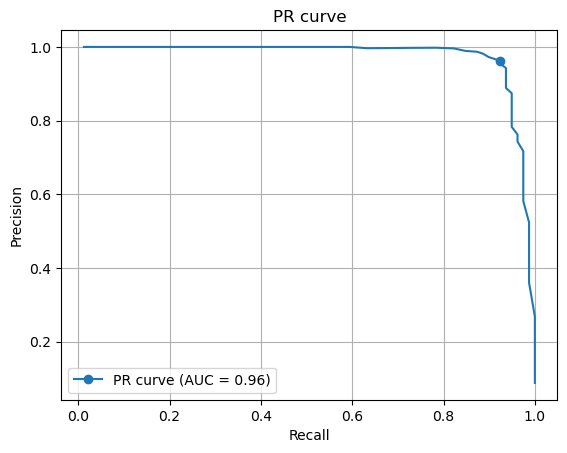

AUC：0.962124538058557
理想の閾値：0.21265822784810126
F値（最高）：0.942847150490846
適合率（最高）：0.9624242424242424
再現率（最高）：0.9240506329113924


In [28]:
print(f'訓練データ（学習用）：{train_day}日目')
print(f'テストデータ（最終評価用）：{test_day}日目')

window=best_params['window']
df_list=[]
for i in train_day:
    lag=[] 
    lag.append(make_data(train_df.loc[train_df['day']==i, ['original']], 'original', window))
    lag.append(train_df.loc[train_df['day']==i, ['label']])
    df_add_lag=pd.concat(lag, axis=1)
    df_list.append(df_add_lag)
train=pd.concat(df_list)
train=train.dropna().reset_index(drop=True)

df_list=[]
for i in test_day:
    lag=[] 
    lag.append(make_data(test_df.loc[test_df['day']==i, ['original']], 'original', window))
    lag.append(test_df.loc[test_df['day']==i, ['label']])
    df_add_lag=pd.concat(lag, axis=1)
    df_list.append(df_add_lag)
test=pd.concat(df_list)
test=test.dropna().reset_index(drop=True)

#特徴量とラベルに分割
train_x=train[train.columns[:-1]]
train_y=train[[train.columns[-1]]]

test_x=test[test.columns[:-1]]
test_y=test[[test.columns[-1]]]

nk=best_params['nk']
neigh = NearestNeighbors(n_neighbors=nk)
neigh.fit(train_x)
d = neigh.kneighbors(test_x)[0]
d = np.mean(d, axis=1)

test_v=test[['original', 'label']].copy().reset_index(drop=True)
test_v['d']=d

#道路交通騒音に埋もれている異常音は正常とする
test_v=leq_filter(test_v)
test_v['d']=test_v['d']/test_v['d'].max()
d_test=test_v['d'].values

print('------------異常検知モデルの性能評価（PR曲線AUC）-------------')
thr_bins=100
p_score, r_score, f_score, thresholds, thr, auc = fig_pr(test_v, d_test, thr_bins)
print('\033[31m'+f'AUC：{auc}'+'\033[0m')
print(f'理想の閾値：{thr}')
print(f'F値（最高）：{f_score.max()}')
print(f'適合率（最高）：{p_score[np.argmax(f_score)]}')
print(f'再現率（最高）：{r_score[np.argmax(f_score)]}')

## 箱ひげ外れ値検知のパラメータチューニング

In [ ]:
print(f'訓練データ（学習用）：{train_day}日目')
print(f'検証データ（チューニング用）：{valid_day}日目')

ratio_list=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
best_score=0

window=best_params['window']
df_list=[]
for i in train_day:
    lag=[] 
    lag.append(make_data(train_df.loc[train_df['day']==i, ['original']], 'original', window))
    lag.append(train_df.loc[train_df['day']==i, ['label']])
    df_add_lag=pd.concat(lag, axis=1)
    df_list.append(df_add_lag)
train=pd.concat(df_list)
train=train.dropna().reset_index(drop=True)

df_list=[]
for i in valid_day:
    lag=[] 
    lag.append(make_data(valid_df.loc[valid_df['day']==i, ['original']], 'original', window))
    lag.append(valid_df.loc[valid_df['day']==i, ['label']])
    df_add_lag=pd.concat(lag, axis=1)
    df_list.append(df_add_lag)
valid=pd.concat(df_list)
valid=valid.dropna().reset_index(drop=True)

#特徴量とラベルに分割
train_x=train[train.columns[:-1]]
train_y=train[[train.columns[-1]]]

valid_x=valid[valid.columns[:-1]]
valid_y=valid[[valid.columns[-1]]]

nk=best_params['nk']
neigh = NearestNeighbors(n_neighbors=nk)
neigh.fit(train_x)
d = neigh.kneighbors(valid_x)[0]
d = np.mean(d, axis=1)

test_v=valid[['original', 'label']].copy().reset_index(drop=True)
test_v['d']=d

#道路交通騒音に埋もれている異常音は正常とする
test_v=leq_filter(test_v)
test_v['d']=test_v['d']/test_v['d'].max()
d_test=test_v['d'].values

#kmeans
n_clusters=2
model = KMeans(n_clusters=n_clusters)  
model.fit(d_test.reshape((-1, 1)))
clusters = model.predict(d_test.reshape((-1, 1)))  
result=pd.DataFrame({'d':d_test, 'cluster':clusters})
thr_list=[]
for j in range(n_clusters):
    thr_list.append(result.loc[result['cluster']==j, 'd'].max())
thr_min=sorted(thr_list)[-2]
thr_max=sorted(thr_list)[-1]

thr_range=result.loc[(result['d']>thr_min)&(result['d']<=thr_max), ['d']]
Q1 = thr_range.quantile(0.25)
Q3 = thr_range.quantile(0.75)
IQR = Q3 - Q1

for r in ratio_list:
    thr = min(float(Q3 + r * IQR), thr_max)
    
    #f値計算
    precision, recall=validate(test_v, d_test, thr)
    f_score=(2*precision*recall)/(precision+recall)
    if f_score>best_score:
        best_score=f_score
        best_params['box_ratio']=r
        print(f'更新F値：{best_score}')
                    
print('==================================================================')
print(f'F値最高：{best_score}')
print(f'パラメータ：{best_params}')

### チューニング結果
* パラメータ：{'window': 5, 'nk': 23, 'box_ratio': 0.1}